Populating the interactive namespace from numpy and matplotlib


d:\python\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
d:\python\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


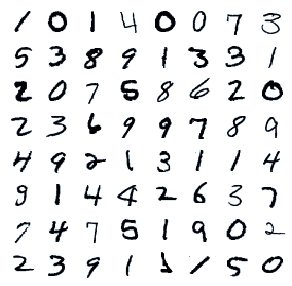

In [4]:
# load the modules

import numpy as np
import pandas as pd
import seaborn as sb
import time
from matplotlib import pylab

sb.set_style("dark")
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

%pylab inline

# We use this function in order to evaulate a classifier. It trains on a fraction of the data corresponding to
# aplit_ratio, and evaulates on the rest of the data

def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)


# read in the data

train = pd.read_csv('train.csv',nrows =1000)
test  = pd.read_csv('test.csv',nrows =500)
target = train["label"]
train = train.drop("label",1)

# plot some of the numbers

plt.figure(figsize(5,5))
for digit_num in range(0,64):
    plt.subplot(8, 8, digit_num + 1)
    grid_data = train.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    plt.xticks([])
    plt.yticks([])



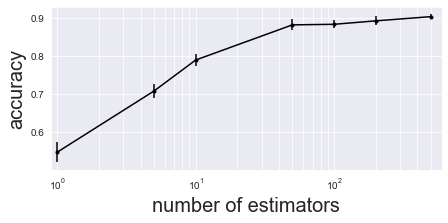

In [5]:
# check performance of random forest classifier, as function of number of estimators 
# here we only take 1000 data points to train

n_estimators_array = np.array([1,5,10,50,100,200,500])
n_samples = 10
n_grid = len(n_estimators_array)
score_array_mu =np.zeros(n_grid)
score_array_sigma = np.zeros(n_grid)
j=0
for n_estimators in n_estimators_array:
    score_array=np.zeros(n_samples)
    for i in range(0,n_samples):
        #start = time.time()
        clf = RandomForestClassifier(n_estimators = n_estimators, n_jobs=1, criterion="gini")
        #end = time.time()
        #print("Running time: ")
        #print(end - start)
        score_array[i] = evaluate_classifier(clf, train.iloc[0:1000], target.iloc[0:1000], 0.8)
    score_array_mu[j], score_array_sigma[j] = mean(score_array), std(score_array)
    j=j+1
    

# it looks like the performace saturates around 50-100 estimators

figure(figsize(7,3))
errorbar(n_estimators_array, score_array_mu, yerr=score_array_sigma, fmt='k.-')
xscale("log")
xlabel("number of estimators",size = 20)
ylabel("accuracy",size = 20)
xlim(0.9,600)
grid(which="both")

Feature ranking:
1. feature 378 (0.009439)
2. feature 406 (0.008484)
3. feature 409 (0.008370)
4. feature 405 (0.007557)
5. feature 433 (0.007451)
6. feature 154 (0.006815)
7. feature 461 (0.006644)
8. feature 381 (0.006543)
9. feature 377 (0.006297)
10. feature 350 (0.006258)


Text(0, 0.5, 'importance')

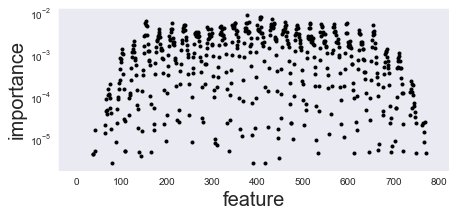

In [3]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(0,10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances

figure(figsize(7,3))
plot(indices[:],importances[indices[:]],'k.')
yscale("log")
xlabel("feature",size=20)
ylabel("importance",size=20)

Text(0, 0.5, 'PC2')

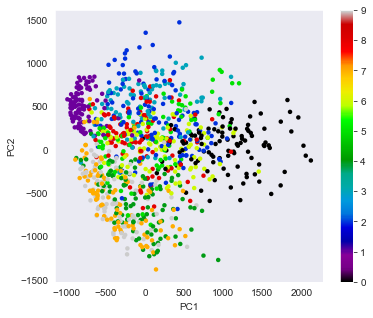

In [4]:
pca = PCA(n_components=2)
pca.fit(train)
transform = pca.transform(train)

figure(figsize(6,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c = target, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
clim(0,9)

xlabel("PC1")
ylabel("PC2")

Text(0, 0.5, 'variance ratio')

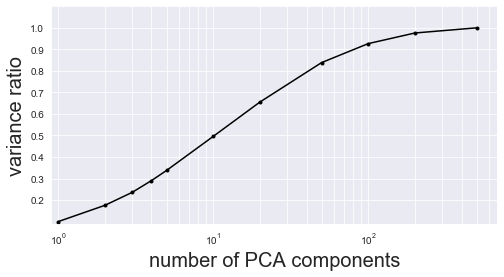

In [5]:
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    vr[i] = sum(pca.explained_variance_ratio_)
    i=i+1    

figure(figsize(8,4))
plot(n_components_array,vr,'k.-')
xscale("log")
ylim(9e-2,1.1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which="both")
xlabel("number of PCA components",size=20)
ylabel("variance ratio",size=20)

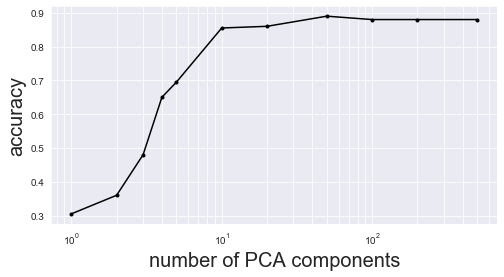

In [6]:
clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
score_array = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    transform = pca.transform(train.iloc[0:1000])
    score_array[i] = evaluate_classifier(clf, transform, target.iloc[0:1000], 0.8)
    i=i+1
    
figure(figsize(8,4))
plot(n_components_array,score_array,'k.-')
xscale('log')
xlabel("number of PCA components", size=20)
ylabel("accuracy", size=20)
grid(which="both")

In [7]:
# PCA + kNN
    
pca = PCA(n_components=50)
pca.fit(train)
transform_train = pca.transform(train)
transform_test = pca.transform(test)

start = time.time()
        
clf = KNeighborsClassifier()
clf.fit(transform_train, target)

end = time.time()
print ("Running time: ")
print (end - start)
results=clf.predict(transform_test)

# prepare submit file

np.savetxt('results.csv', 
           np.c_[range(1,len(test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')


Running time: 
0.0029757022857666016


In [8]:
# random forest classification

clf = RandomForestClassifier(n_estimators = 100, n_jobs=1, criterion="gini")
clf.fit(train, target)
results=clf.predict(test)

# prepare submit file

np.savetxt('results.csv', 
           np.c_[range(1,len(test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')